# Import the necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# for model
import tensorflow as tf
import keras
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
import warnings
warnings.simplefilter("ignore")

import cv2 as cv

import os
dataset_path = "/kaggle/input/e-commerce-products-images/"
image_path = "/kaggle/input/e-commerce-products-images/e-commerce/images/"
os.listdir(dataset_path)

2024-02-21 07:20:02.192189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 07:20:02.192297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 07:20:02.361612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['styles.csv', 'e-commerce']

# Load the dataset

In [2]:
df = pd.read_csv(dataset_path + "styles.csv")

In [3]:
# Add columns
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)

In [4]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [5]:
df.shape

(44441, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44441 entries, 0 to 44440
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44441 non-null  int64  
 1   gender              44441 non-null  object 
 2   masterCategory      44441 non-null  object 
 3   subCategory         44441 non-null  object 
 4   articleType         44441 non-null  object 
 5   baseColour          44426 non-null  object 
 6   season              44420 non-null  object 
 7   year                44440 non-null  float64
 8   usage               44124 non-null  object 
 9   productDisplayName  44434 non-null  object 
 10  image               44441 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.7+ MB


# Handling missing values in the dataset

In [7]:
df.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
image                   0
dtype: int64

In [8]:
df['baseColour'] = df['baseColour'].fillna(df['baseColour'].mode().iloc[0])
df['season'] = df['season'].fillna(df['season'].mode().iloc[0])
df['year'] = df['year'].fillna(df['year'].mode().iloc[0])
df['baseColour'] = df['baseColour'].fillna(df['baseColour'].mode().iloc[0])
df['usage'] = df['usage'].fillna(df['usage'].mode().iloc[0])

In [9]:
df.isnull().sum()

id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    7
image                 0
dtype: int64

# Visualization

In [10]:
# Number of men's items vs Number of women's items
fig = px.pie(df, df['gender'],color_discrete_sequence=px.colors.sequential.RdBu, 
             title="Number of men's items vs Number of women's items")

fig.show()

In [11]:
catcounts=pd.value_counts(df['masterCategory'])

fig = go.Figure([go.Bar(x=catcounts.index, y=catcounts.values , text=catcounts.values,
                        marker_color='darkblue')])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

In [12]:
seasons=pd.value_counts(df['season'])

fig = go.Figure(data=[go.Scatter(
    x=seasons.index, y=seasons.values,
    mode='markers',
    marker=dict(
        color=['rgb(93, 164, 214)', 'rgb(255, 144, 14)',
               'rgb(44, 160, 101)', 'rgb(255, 65, 54)'],
        opacity=[1, 0.8, 0.6, 0.4],
        size=[40, 60, 80, 100])
)])

fig.show()

<Axes: xlabel='gender', ylabel='count'>

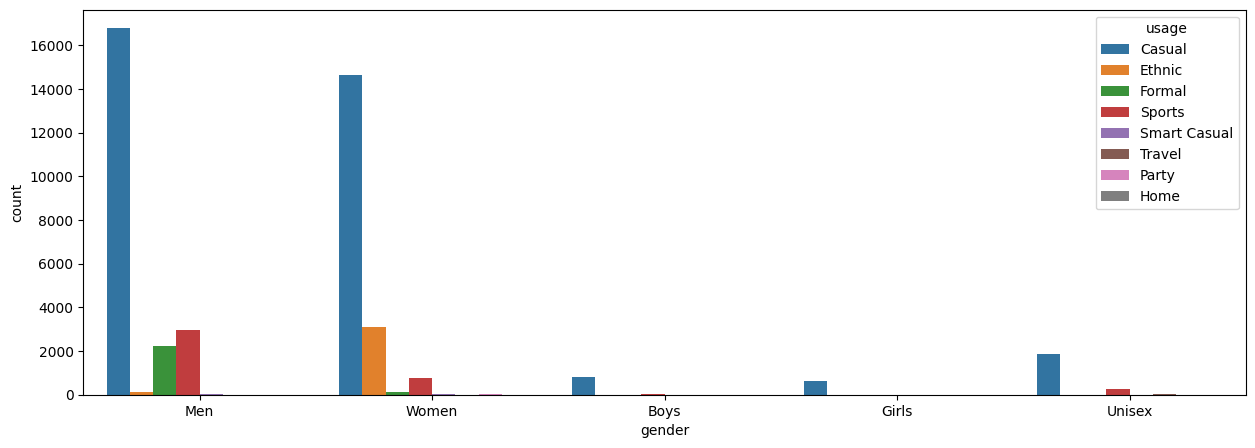

In [13]:
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x=df['gender'], hue=df['usage'])

<Axes: xlabel='gender', ylabel='count'>

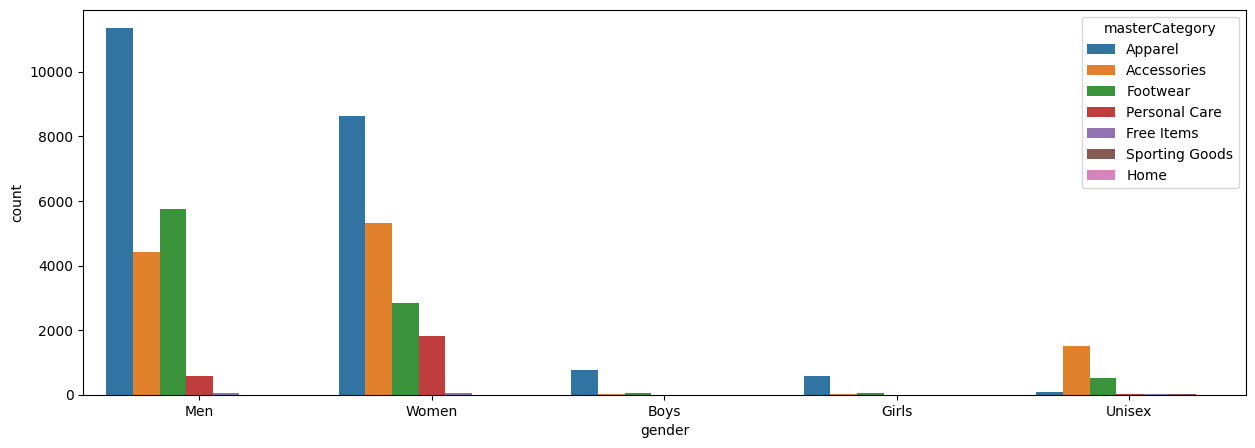

In [14]:
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x=df['gender'], hue=df['masterCategory'])

In [15]:
articles=pd.value_counts(df['articleType'])
fig = go.Figure([go.Bar(x=articles.index, y=articles.values , text=articles.values,marker_color='indianred')])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

# Data Preprocessing

In [16]:
def plot_figures(figures, nrows = 1, ncols=1,figsize=(14, 14)):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        ax.ravel()[ind].imshow(cv.cvtColor(figures[title], cv.COLOR_BGR2RGB))
        ax.ravel()[ind].set_title(title)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    
def img_path(img):
    return image_path + img

def load_image(img, resized_fac = 0.1):
    img     = cv.imread(img_path(img))
    # w, h, _ = img.shape
    # resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return img

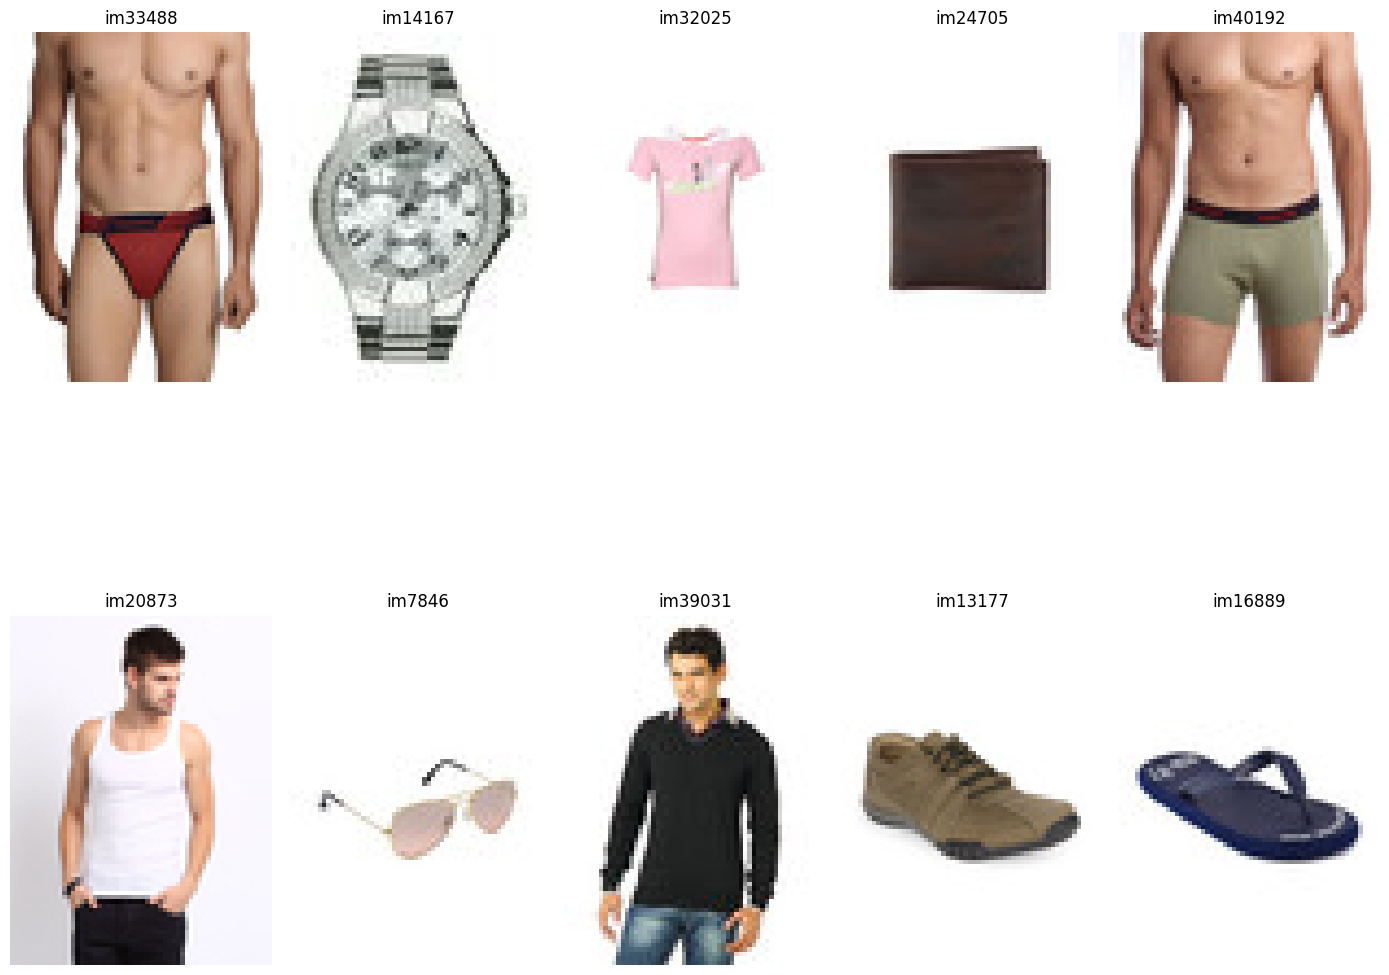

In [17]:
figures = {'im'+str(i): load_image(row['image']) for i, row in df.sample(10).iterrows()}
plot_figures(figures, 2, 5)

# Use Pre-Trained Model to Recommendation

In [18]:
# Input Shape
img_width, img_height, _ = 128, 128, 3 #load_image(df.iloc[0].image).shape

In [19]:
# Pre-Trained Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [20]:
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [22]:
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    
    predict = model.predict(x).reshape(-1)
    return predict

In [23]:
emb = get_embedding(model, df.iloc[0].image)

1/1 [==============================] - 4s 4s/step


(80, 60, 3)
[ 0.7259641 14.1860695  0.        ...  5.414736   0.        10.539306 ]


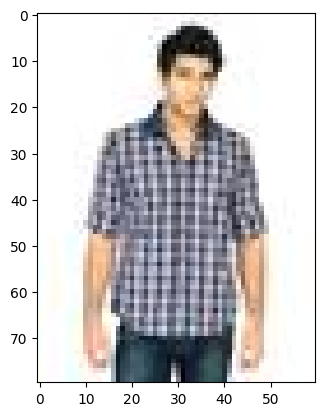

In [24]:
img_array = load_image(df.iloc[0].image)
plt.imshow(cv.cvtColor(img_array, cv.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [25]:
# Parallel apply
df_sample = df #.sample(10)
map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, img))
df_embs = map_embeddings.apply(pd.Series)

1/1 [==============================] - 0s 25ms/step


In [26]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[1.        , 0.65058064, 0.357687  , 0.561216  ],
       [0.65058064, 1.        , 0.3174793 , 0.7451474 ],
       [0.357687  , 0.3174793 , 1.        , 0.30659592],
       [0.561216  , 0.7451474 , 0.30659592, 0.99999976]], dtype=float32)

# Recommender Similar Items

In [27]:
indices = pd.Series(range(len(df)), index=df.index)
indices

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(2993, df, top_n = 5)

(Index([40290, 5766, 14689, 24239, 19951], dtype='int64'),
 [1.0, 0.93085194, 0.9240595, 0.9240595, 0.9206019])

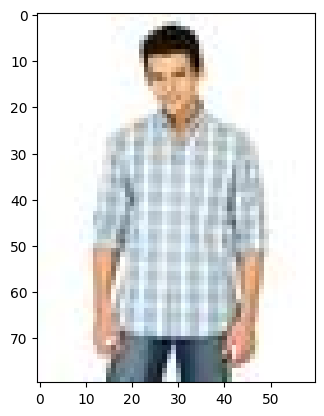

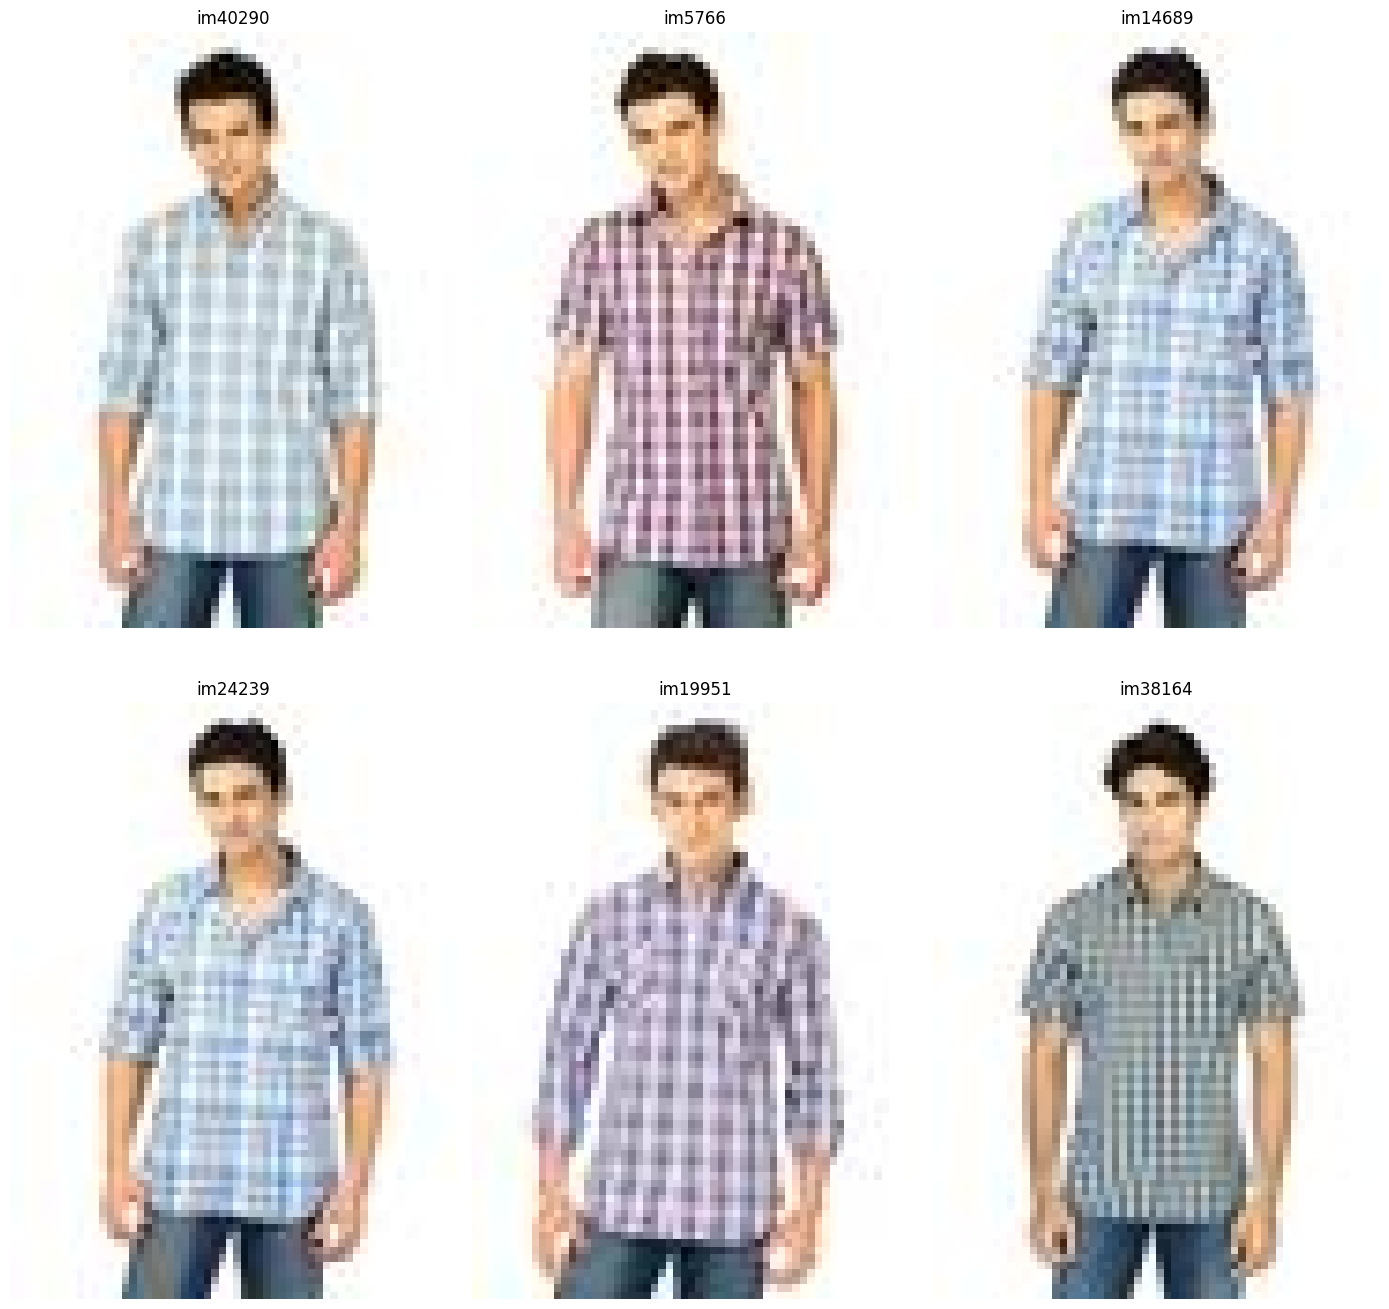

In [28]:
# Idx Item to Recommender
idx_ref = 2993

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv.cvtColor(load_image(df.iloc[idx_ref].image), cv.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)